Using Close prices
Data shape: (2775, 3)


Ticker,BND,SPY,TSLA
Date,,,
2015-01-02,60.385941,170.589584,14.620667
2015-01-05,60.561321,167.508850,14.006000
2015-01-06,60.736671,165.931061,14.085333
2015-01-07,60.773220,167.998749,14.063333
2015-01-08,60.678246,170.979874,14.041333


Missing values after cleaning: 0


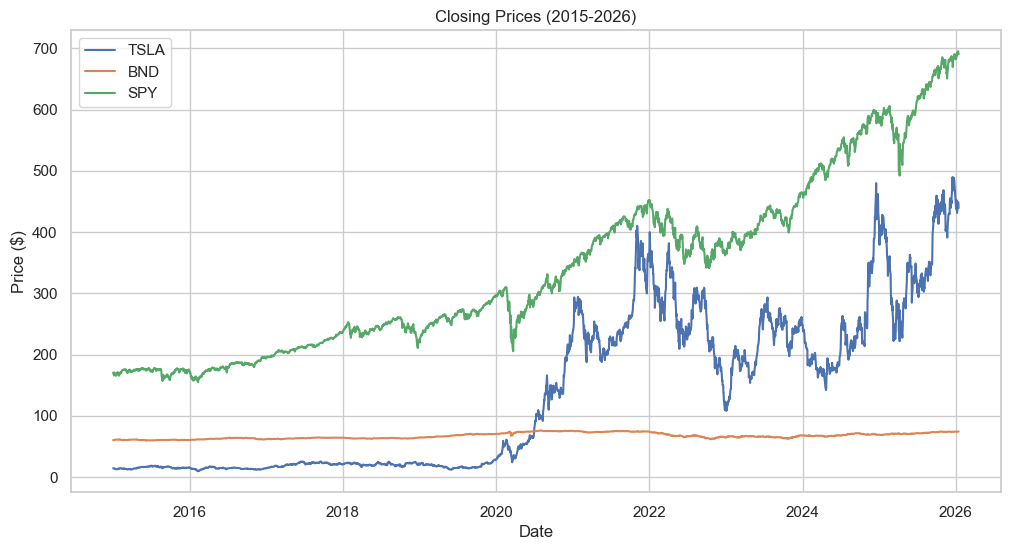

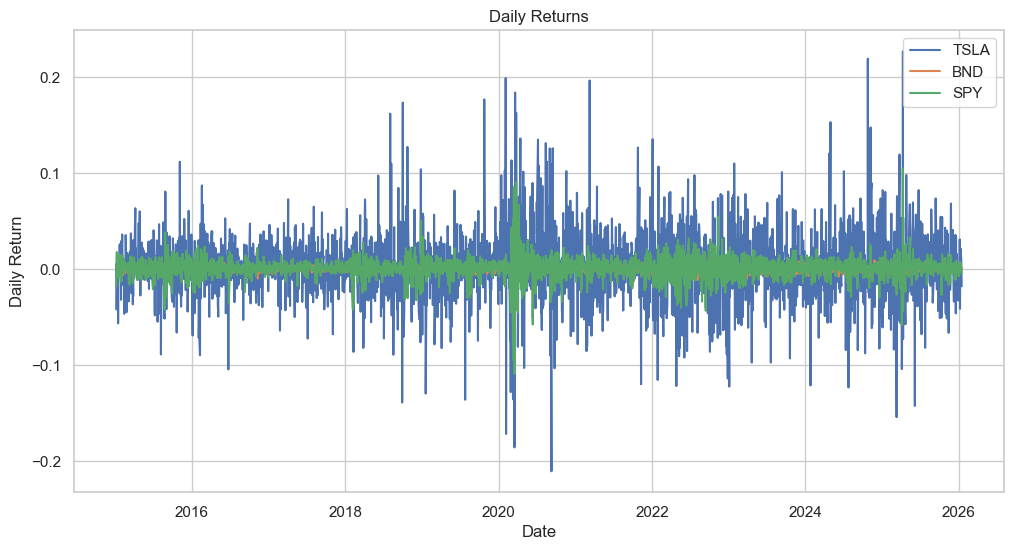

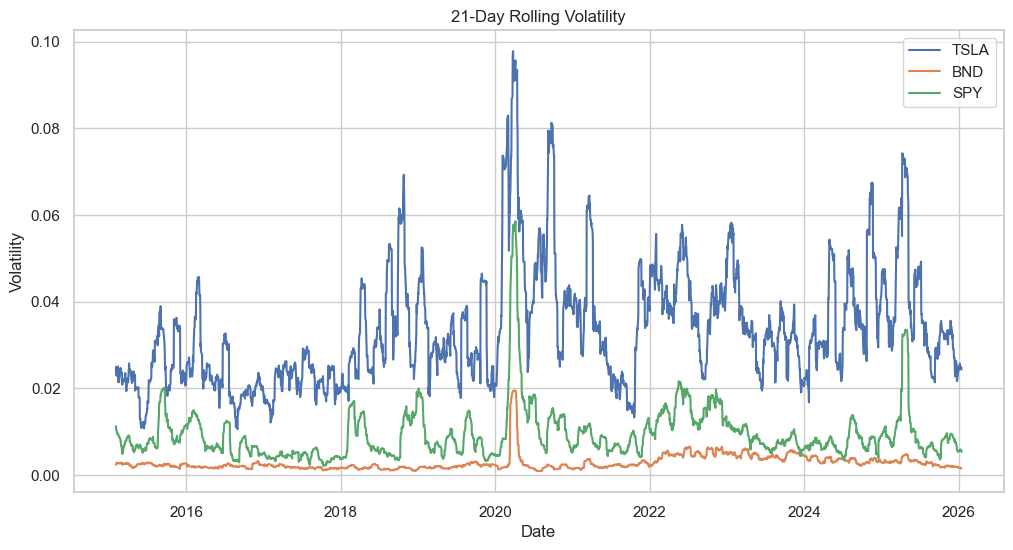

TSLA: 48 outlier days
BND: 31 outlier days
SPY: 36 outlier days

ADF Test for TSLA:
ADF Statistic: -0.7802
p-value: 0.8249
Non-stationary

ADF Test for BND:
ADF Statistic: -1.0514
p-value: 0.7341
Non-stationary

ADF Test for SPY:
ADF Statistic: 1.1709
p-value: 0.9958
Non-stationary

Risk Metrics Summary:


,Annualized Return,Annualized Volatility,Sharpe Ratio,VaR 95%
Ticker,,,,
BND,0.020434,0.053567,0.381459,-0.004796
SPY,0.142850,0.177676,0.803992,-0.016719
TSLA,0.474914,0.576923,0.823185,-0.052529


Data saved to 'data/processed/' folder


In [21]:
# ================================
# Task 1: Preprocess and Explore the Data
# ================================

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,6)

# -------------------------
# 1. Download Historical Data
# -------------------------
tickers = ["TSLA", "BND", "SPY"]
start_date = "2015-01-01"
end_date = "2026-01-15"

data_hist = yf.download(tickers, start=start_date, end=end_date, progress=False)

# Handle multi-index vs single-level columns
if isinstance(data_hist.columns, pd.MultiIndex):
    if 'Adj Close' in data_hist.columns.get_level_values(0):
        data = data_hist['Adj Close'].copy()
        print("Using Adjusted Close prices")
    else:
        data = data_hist['Close'].copy()
        print("Using Close prices")
else:
    # Single-level columns
    if 'Adj Close' in data_hist.columns:
        data = data_hist['Adj Close'].copy()
        print("Using Adjusted Close prices")
    else:
        data = data_hist.copy()
        print("Using Close prices")

print("Data shape:", data.shape)
display(data.head())

# -------------------------
# 2. Data Cleaning
# -------------------------
# Fill missing values forward/backward
data = data.ffill().bfill()
print("Missing values after cleaning:", data.isna().sum().sum())

# -------------------------
# 3. Exploratory Data Analysis (EDA)
# -------------------------

# 3a. Plot closing prices
plt.figure()
for ticker in tickers:
    plt.plot(data[ticker], label=ticker)
plt.title("Closing Prices (2015-2026)")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.show()

# 3b. Daily Returns
returns = data.pct_change().dropna()
plt.figure()
for ticker in tickers:
    plt.plot(returns[ticker], label=ticker)
plt.title("Daily Returns")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.show()

# 3c. Rolling Volatility (21-day)
rolling_vol = returns.rolling(window=21).std()
plt.figure()
for ticker in tickers:
    plt.plot(rolling_vol[ticker], label=ticker)
plt.title("21-Day Rolling Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

# 3d. Outlier detection
for ticker in tickers:
    outliers = returns[np.abs(returns[ticker]) > 3*returns[ticker].std()]
    print(f"{ticker}: {len(outliers)} outlier days")

# -------------------------
# 4. Stationarity Test (ADF)
# -------------------------
for ticker in tickers:
    print(f"\nADF Test for {ticker}:")
    result = adfuller(data[ticker].dropna())
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Stationary" if result[1] < 0.05 else "Non-stationary")

# -------------------------
# 5. Risk Metrics
# -------------------------
# Historical mean returns and volatility
mean_returns = returns.mean() * 252  # annualized
volatility = returns.std() * np.sqrt(252)

# Sharpe ratio (risk-free rate assumed 0)
sharpe_ratio = mean_returns / volatility

# Value at Risk (VaR) 95%
var_95 = returns.quantile(0.05)

risk_metrics = pd.DataFrame({
    "Annualized Return": mean_returns,
    "Annualized Volatility": volatility,
    "Sharpe Ratio": sharpe_ratio,
    "VaR 95%": var_95
})

print("\nRisk Metrics Summary:")
display(risk_metrics)

# -------------------------
# 6. Save Cleaned Data and Returns
# -------------------------
data.to_csv("../data/processed/historical_prices.csv")
returns.to_csv("../data/processed/daily_returns.csv")
print("Data saved to 'data/processed/' folder")
